In [2]:
import logging
import sys

import torch
import torch.nn as nn
from torch.distributions import constraints

import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO, TraceTMC_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.ops.indexing import Vindex
from pyro.optim import Adam
from pyro.util import ignore_jit_warnings

import visualization as V

%load_ext autoreload
%autoreload 2

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.DEBUG)

log = logging.getLogger()
debug_handler = logging.StreamHandler(sys.stdout)
debug_handler.setLevel(logging.DEBUG)
debug_handler.addFilter(filter=lambda record: record.levelno <= logging.DEBUG)
log.addHandler(debug_handler)


cuda = True
num_steps = 20
learning_rate = .05
tmc_num_samples = 100
seed = 0
batch_size = 16
hidden_dim = 16

In [3]:
# %% Models

def HMM(sequences, lengths, hidden_dim, batch_size=None, include_prior=True, jit=True):
    num_sequences, max_length, data_dim = map(int, sequences.shape)
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1))
        probs_y = pyro.sample("probs_y",dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2))
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lengths = lengths[batch]
        x = 0
        for t in pyro.markov(range(max_length if jit else lengths.max())):
            with poutine.mask(mask=(t < lengths).unsqueeze(-1)):
                x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
                with obs_plate:
                    pyro.sample("y_{}".format(t),dist.Bernoulli(probs_y[x.squeeze(-1)]),obs=sequences[batch, t])


def ARHMM(sequences, lengths, hidden_dim, batch_size=None, include_prior=True, jit=True):
    num_sequences, max_length, data_dim = map(int, sequences.shape)
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1))
        probs_y = pyro.sample("probs_y",dist.Beta(0.1, 0.9).expand([hidden_dim, 2, data_dim]).to_event(3))
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lengths = lengths[batch]
        x, y = 0, 0
        for t in pyro.markov(range(max_length if jit else lengths.max())):
            with poutine.mask(mask=(t < lengths).unsqueeze(-1)):
                x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
                with obs_plate as obs:
                    y = pyro.sample("y_{}".format(t),dist.Bernoulli(probs_y[x, y, obs]),obs=sequences[batch, t]).long()


In [4]:
# %% Training

if cuda: torch.set_default_tensor_type("torch.cuda.FloatTensor")

logging.info("Loading data")
data = poly.load_data(poly.JSB_CHORALES)

logging.info("-" * 40)
sequences = data["train"]["sequences"]
lengths = data["train"]["sequence_lengths"]

present_notes = (sequences == 1).sum(0).sum(0) > 0
sequences = sequences[..., present_notes]

num_observations = float(lengths.sum())
pyro.set_rng_seed(seed)
pyro.clear_param_store()

guide = AutoDelta(poutine.block(HMM, expose_fn=lambda msg: msg["name"].startswith("probs_")))

optim = Adam({"lr": learning_rate})
elbo = TraceTMC_ELBO(max_plate_nesting=2)
tmc_model = poutine.infer_config(HMM,
    lambda msg: {"num_samples": tmc_num_samples, "expand": False} if msg["infer"].get("enumerate", None) == "parallel" else {},
)
svi = SVI(tmc_model, guide, optim, elbo)

for step in range(num_steps):
    loss = svi.step(sequences, lengths, hidden_dim=hidden_dim, batch_size=batch_size)
    logging.info("{: >5d}\t{}".format(step, loss / num_observations))


    40362 Loading data
    42239 ----------------------------------------
    44141     0	18.52133655030057
    45290     1	23.336733631491274
    46410     2	19.71230399435069
    47497     3	19.86661204461505
    48607     4	21.844175508799886
    49665     5	17.492517382487144
    50808     6	20.489959802998477
    52007     7	20.787060005794164
    53117     8	18.61034144817846
    54297     9	16.19156270370102
    55382    10	18.52508691243572
    56567    11	16.3285199536467
    57638    12	14.00416342253929
    58801    13	22.605772886941406
    59890    14	19.443466176577097
    61080    15	17.089746143260665
    62174    16	16.40240910407764
    63297    17	19.232581299340914
    64368    18	15.167325677192729
    65462    19	17.77497487687405


In [5]:
# %% Evaluation

train_loss = elbo.loss(HMM, guide, sequences, lengths, hidden_dim=hidden_dim, include_prior=False)
logging.info("training loss = {}".format(train_loss / num_observations))

logging.info("-" * 40)
logging.info("Evaluating on {} test sequences".format(len(data["test"]["sequences"])))

sequences = data["test"]["sequences"][..., present_notes]
lengths = data["test"]["sequence_lengths"]
num_observations = float(lengths.sum())

test_loss = elbo.loss(HMM, guide, sequences, lengths, hidden_dim=hidden_dim, include_prior=False)
logging.info("test loss = {}".format(test_loss / num_observations))

capacity = sum(value.reshape(-1).size(0) for value in pyro.get_param_store().values())
logging.info("{} capacity = {} parameters".format(HMM.__name__, capacity))


    66470 training loss = 21.109328601434054
    66471 ----------------------------------------
    66472 Evaluating on 77 test sequences
    67330 test loss = 21.020522486772485
    67331 HMM capacity = 1072 parameters


In [6]:
def HMM_Generate(shape, lengths, hidden_dim, batch_size=None, include_prior=True, jit=True):
    num_sequences, max_length, data_dim = map(int, shape)
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1))
        probs_y = pyro.sample("probs_y",dist.Normal(torch.tensor([0,0,0]).float(),10.0).expand([hidden_dim, data_dim]).to_event(2))
#         probs_y = pyro.sample("probs_y",dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2))
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    X = []
    Y = []
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lengths = lengths[batch]
        x = 0
        for t in pyro.markov(range(max_length if jit else lengths.max())):
            with poutine.mask(mask=(t < lengths).unsqueeze(-1)):
                x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
                X.append(x)
                with obs_plate:
#                     y = pyro.sample("y_{}".format(t),dist.Bernoulli(probs_y[x.squeeze(-1)]))
                    y = pyro.sample("y_{}".format(t),dist.Normal(probs_y[x.squeeze(-1)],1.0))
                    Y.append(y)
    return torch.stack(X), torch.stack(Y)

def ARHMM_Generate(shape, lengths, hidden_dim, batch_size=None, include_prior=True, jit=True):
    num_sequences, max_length, data_dim = map(int, shape)
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample("probs_x",dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1))
        probs_y = pyro.sample("probs_y",dist.Normal(torch.tensor([0,0,0]).float(),10.0).expand([hidden_dim, data_dim]).to_event(2))
#         probs_y = pyro.sample("probs_y",dist.Beta(0.1, 0.9).expand([hidden_dim, 2, data_dim]).to_event(3))
        
    obs_plate = pyro.plate("obs", data_dim, dim=-1)
    
    X = []
    Y = []
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lengths = lengths[batch]
        x, y = 0, 0
        for t in pyro.markov(range(max_length if jit else lengths.max())):
            with poutine.mask(mask=(t < lengths).unsqueeze(-1)):
                x = pyro.sample("x_{}".format(t),dist.Categorical(probs_x[x]),infer={"enumerate": "parallel"})
                X.append(x)
                with obs_plate as obs:
                    y = .9*y + pyro.sample("y_{}".format(t),dist.Normal(probs_y[x.squeeze(-1)],1.0))
#                     y = pyro.sample("y_{}".format(t),dist.Bernoulli(probs_y[x, y, obs])).long()
                    Y.append(y)

    return torch.stack(X), torch.stack(Y)

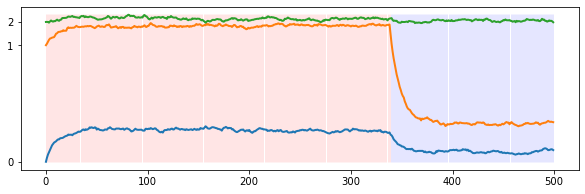

In [9]:
X, Y = ARHMM_Generate([1,500,3], lengths*0+500, 4)
V.plot_signals(Y[:,0,:].cpu(),z=X[:,0,0].cpu())